# **Analysis of NYC Yellow Taxi Trip Data with PySpark**

## Project Overview

This project performs an end-to-end analysis of the New York City Yellow Taxi trip records from January 2024. The primary goal is to process, clean, enrich, and analyze this large dataset to extract meaningful insights.

### Objectives:
* **Ingest** raw data from a Parquet file.
* **Clean and pre-process** the data to ensure quality and consistency.
* **Enrich the dataset** through feature engineering and by joining it with external location data.
* **Perform exploratory data analysis (EDA)** and aggregations to uncover key business insights.
* **Optimize Spark operations** for performance.
* **Export** the final, curated dataset for downstream use.

### Technologies Used:
* **Apache Spark (PySpark):** For distributed data processing and analysis.
* **Pandas & Matplotlib:** For data manipulation and visualization within the notebook.
* **Parquet:** As the file format for efficient data storage and retrieval.

In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Stop any existing Spark session to start fresh
spark.stop()

# Initialize SparkSession with optimized configurations
spark = SparkSession.builder \
    .appName('NYC_Taxi_Analysis') \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.parquet.filterPushdown", "true") \
    .getOrCreate()

spark

25/09/15 18:33:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## **1. Data Ingestion**

The first step is to load the raw taxi trip data. The data is stored in the Parquet format, which is a highly efficient, column-oriented data format well-suited for big data analytics. For development purposes, we will limit the dataset to the first 1 million records to ensure faster iteration.

In [3]:
# Define the schema to ensure data consistency and faster reads
taxi_schema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampNTZType(), True),
    StructField("tpep_dropoff_datetime", TimestampNTZType(), True),
    StructField("passenger_count", LongType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", LongType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("PULocationID", IntegerType(), True),
    StructField("DOLocationID", IntegerType(), True),
    StructField("payment_type", LongType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True),
    StructField("Airport_fee", DoubleType(), True)
])

# Load the raw dataset from a Parquet files that have the data for all months in 2024
# The .limit() function is used here to manage resources during development.
df_raw = spark.read.schema(taxi_schema).parquet('./data/yellow_tripdata_2024-01.parquet')

# Display the schema to understand the data types and column names
df_raw.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [4]:
df_raw.count()

2964624

In [5]:
# Displaying the raw data
df_raw.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.80,1,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.70,1,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.40,1,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.80,1,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## **2. Data Cleaning**

Data quality is crucial for any reliable analysis. In this section, we perform several cleaning operations:
* **Standardize Column Names:** Remove any leading/trailing whitespace from column names.
* **Drop Irrelevant Columns:** Remove columns that are not needed for this analysis, such as `RatecodeID` and `store_and_fwd_flag`.
* **Filter Invalid Records:** Apply business rules to filter out rows with poor data quality. This includes trips with null pickup/dropoff times, trips with a distance of zero or an extreme value, and trips with a negative `total_amount`.

In [6]:
# Standardize column names by stripping whitespace
df_renamed = df_raw
for c in df_renamed.columns:
    df_renamed = df_renamed.withColumnRenamed(c, c.strip())

In [7]:
# Drop columns that are not required for the analysis
df_dropped = df_renamed.drop(
    'RatecodeID',
    'store_and_fwd_flag',
    'improvement_surcharge',
    'congestion_surcharge',
    'Airport_fee'
)

In [8]:
# Filter rows based on logical business rules
df_cleaned = df_dropped.filter(
    (F.col('tpep_pickup_datetime').isNotNull()) &
    (F.col('tpep_dropoff_datetime').isNotNull()) &
    (F.col('trip_distance').between(0.1, 300)) &
    (F.col('total_amount') >= 0)
)

### Data Quality Checks

### Caching DataFrame

In [9]:
from pyspark.storagelevel import StorageLevel
df_cleaned.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, total_amount: double]

In [10]:
# Display the dataframe
df_cleaned.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,186,79,2,17.7,1.0,0.5,0.00,0.0,22.70
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.80,140,236,1,10.0,3.5,0.5,3.75,0.0,18.75
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.70,236,79,1,23.3,3.5,0.5,3.00,0.0,31.30
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.40,79,211,1,10.0,3.5,0.5,2.00,0.0,17.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.80,211,148,1,7.9,3.5,0.5,3.20,0.0,16.10


## **3. Feature Engineering**

To enable deeper analysis, we create new features from existing columns. These features provide valuable context about each trip:
* **`trip_duration_sec`**: The total duration of the trip in seconds.
* **`average_speed_mph`**: The average speed of the taxi during the trip.
* **`trip_category`**: A categorical label for the trip distance (short, medium, long).
* **Time-based Features**: `pickup_hour`, `day_of_week`, `month`, and `is_weekend` are extracted to analyze temporal patterns.

In [11]:
# Adding columns to enrich the dataframe

df_enriched = (df_cleaned
    # Calculate the total trip duration in seconds
    .withColumn("trip_duration_sec", 
                F.unix_timestamp(F.col("tpep_dropoff_datetime")) - F.unix_timestamp(F.col("tpep_pickup_datetime")))
    
    # Calculate the average speed in miles per hour
    .withColumn("average_speed_mph", 
                F.round(F.col('trip_distance') / (F.col('trip_duration_sec') / 3600), 2))
    
    # Categorize trips based on their distance
    .withColumn('trip_category', 
                F.when(F.col('trip_distance') <= 2, 'short')
                 .when((F.col('trip_distance') > 2) & (F.col('trip_distance') <= 10), 'medium')
                 .otherwise('long'))
    
    # Extract time-based features from the pickup datetime
    .withColumn('pickup_hour', F.hour('tpep_pickup_datetime'))
    .withColumn('day_of_week', F.dayofweek('tpep_pickup_datetime'))
    .withColumn('month', F.month('tpep_pickup_datetime'))
    
    # Determine if the trip occurred on a weekend or weekday
    .withColumn('is_weekend', 
                F.when(F.col('day_of_week').isin([1, 7]), 'Weekend')
                 .otherwise('Weekday'))
)

In [12]:
# Display a sample of the enriched data
df_enriched.select(
    "trip_distance", "trip_duration_sec", "average_speed_mph",
    "trip_category", "pickup_hour", "day_of_week", "is_weekend"
).limit(5).toPandas()

,trip_distance,trip_duration_sec,average_speed_mph,trip_category,pickup_hour,day_of_week,is_weekend
0,1.72,1188,5.21,short,0,2,Weekday
1,1.80,396,16.36,short,0,2,Weekday
2,4.70,1075,15.74,medium,0,2,Weekday
3,1.40,498,10.12,short,0,2,Weekday
4,0.80,366,7.87,short,0,2,Weekday


## **4. Exploratory Data Analysis (EDA)**

EDA helps us understand the underlying patterns and distributions in the data. Here, we investigate:
* **Busiest Locations:** The top 5 pickup and dropoff locations by trip count.
* **Trip Distance Distribution:** A bar chart visualizing the frequency of trips by distance.
* **Hourly Demand:** A bar chart showing the number of trips for each hour of the day.
* **Fare by Passenger Count:** The average fare amount based on the number of passengers.

In [13]:
# Top 5 Pickup Locations
print("Top 5 Pickup Locations")
df_enriched.groupBy('PULocationID').count().orderBy('count', ascending=False).limit(5).toPandas()

Top 5 Pickup Locations


,PULocationID,count
0,161,139975
1,237,139974
2,132,137509
3,236,133860
4,162,104203


In [14]:
# Top 5 Dropoff Locations
print("Top 5 Dropoff Locations")
df_enriched.groupBy('DOLocationID').count().orderBy('count', ascending=False).limit(5).toPandas()

Top 5 Dropoff Locations


,DOLocationID,count
0,236,139294
1,237,127549
2,161,109056
3,142,87544
4,230,87384


In [15]:
# Average Fare by Passenger Count
print("Average Fare by Passenger Count")
df_enriched.groupBy('passenger_count') \
    .agg(F.round(F.avg('fare_amount'), 2).alias('AverageFare')) \
    .orderBy('passenger_count').limit(5).toPandas()

Average Fare by Passenger Count


,passenger_count,AverageFare
0,NaN,19.98
1,0.0,16.49
2,1.0,17.88
3,2.0,20.53
4,3.0,20.37


Plotting Distribution of Pickup Hour...


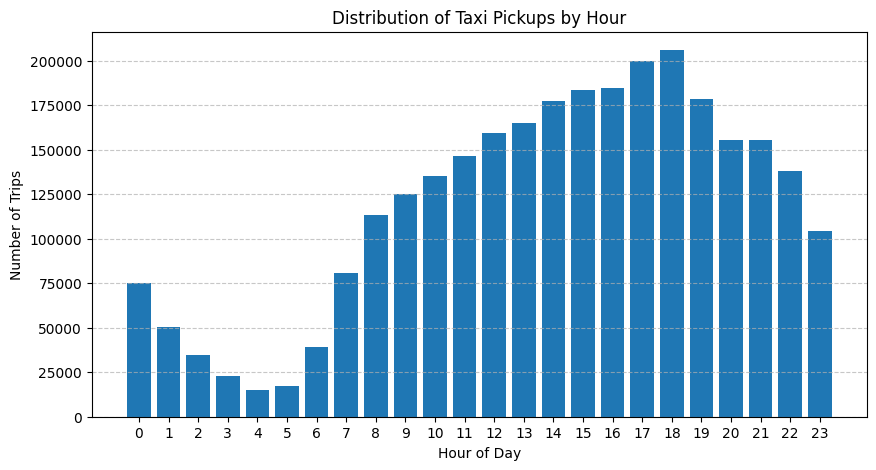

In [16]:
# Plotting distribution of Pickup Hour
print("Plotting Distribution of Pickup Hour...")
pickup_hour_df = df_enriched.groupBy('pickup_hour').count().toPandas()
plt.figure(figsize=(10, 5))
plt.bar(pickup_hour_df['pickup_hour'], pickup_hour_df['count'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Taxi Pickups by Hour')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

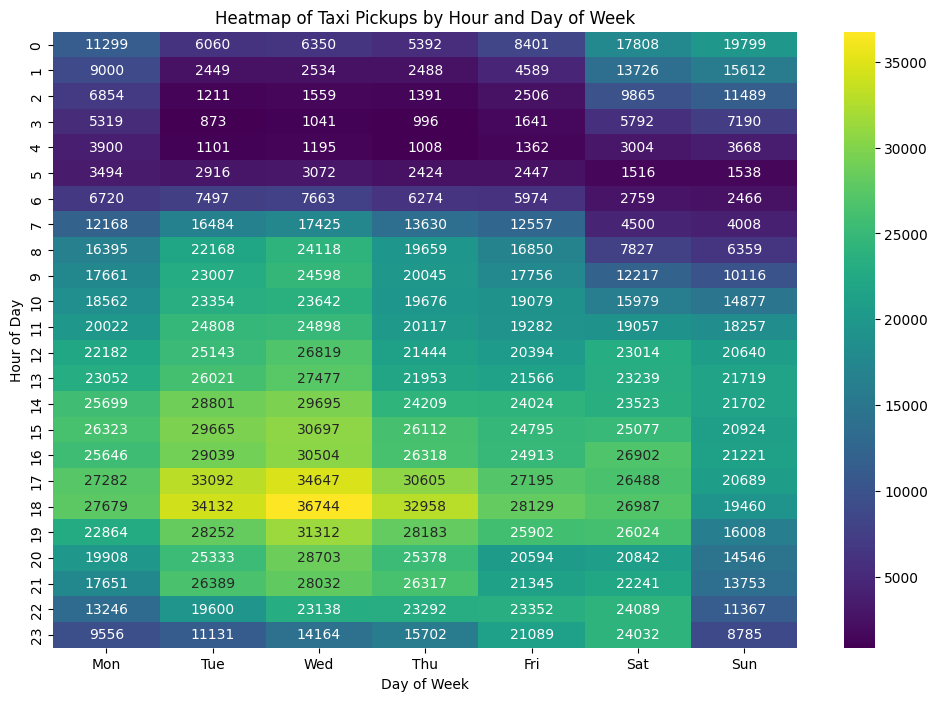

In [17]:
# Creating a new column with the string representation of the day of the week (e.g., 'Mon')
df_with_day_str = df_enriched.withColumn("day_of_week_str", F.date_format('tpep_pickup_datetime', 'E'))

# Grouping by hour and pivot on the NEW column NAME
heatmap_data = df_with_day_str.groupBy("pickup_hour") \
    .pivot("day_of_week_str", ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) \
    .count() \
    .fillna(0) \
    .toPandas()

# Sort by hour and set it as the index for correct plotting
heatmap_data = heatmap_data.sort_values('pickup_hour').set_index('pickup_hour')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt="d")
plt.title('Heatmap of Taxi Pickups by Hour and Day of Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.show()

## **5. Data Enrichment and Business Insights**

In this section, we move from general exploration to answering specific business questions. We first enrich the dataset by joining it with a location lookup table to get borough and zone information. We use a **broadcast join** since the location table is small, which is a key Spark optimization technique.

After joining, we can derive insights such as:
* Total revenue per month.
* Average trip distance by day of the week.
* Busiest days by earnings.
* Tip percentage differences between weekdays and weekends.
* Trip distribution across different NYC boroughs.

In [18]:
# Load the location lookup table
location_lkp = spark.read.csv('./data/location_lookup.csv', header=True, inferSchema=True)

In [19]:
# Perform a broadcast join to enrich the main DataFrame with location details
# F.broadcast() sends the small lookup DataFrame to all worker nodes for an efficient join.
df_joined = df_enriched.join(
    F.broadcast(location_lkp),
    df_enriched['PULocationID'] == location_lkp['LocationID'],
    how='left'
).select(
    df_enriched['*'],
    location_lkp['Borough'],
    location_lkp['Zone']
)

### Business Insights

In [20]:
# Revenue per month
print("Total Revenue per Month")
df_joined.groupBy('month').agg(F.round(F.sum('total_amount'), 2).alias('Revenue/month')).limit(5).toPandas()

Total Revenue per Month


,month,Revenue/month
0,12,235.12
1,1,78229746.66
2,2,90.47


In [21]:
# Average trip distance per day
print("Average Trip Distance by Day of the Week")
df_joined.groupBy(F.date_format('tpep_pickup_datetime', 'EEEE').alias('day')) \
    .agg(F.round(F.avg('trip_distance'), 2).alias('avg_distance')) \
    .limit(5).toPandas()

Average Trip Distance by Day of the Week


25/09/15 18:34:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,day,avg_distance
0,Friday,3.21
1,Monday,3.71
2,Sunday,3.57
3,Thursday,3.23
4,Wednesday,3.22


In [22]:
# Tip percentage for weekdays vs. weekends
print("Tip Percentage on Weekdays vs. Weekends")
df_joined.groupBy('is_weekend') \
    .agg(F.round((F.sum('tip_amount') / F.sum('total_amount')) * 100, 2).alias('tip_percentage')) \
    .limit(5).toPandas()

Tip Percentage on Weekdays vs. Weekends


,is_weekend,tip_percentage
0,Weekday,12.46
1,Weekend,12.43


In [23]:
# Number of trips by Borough
print("Total Trips by Borough")
df_joined.groupBy('Borough').count().orderBy('count', ascending=False).limit(5).toPandas()

Total Trips by Borough


,Borough,count
0,Manhattan,2570480
1,Queens,256327
2,Brooklyn,22214
3,Unknown,9530
4,Bronx,5742


In [24]:
# Find the top 3 longest-duration trips for each borough
window_spec = Window.partitionBy("Borough").orderBy(F.col("trip_duration_sec").desc())

df_ranked_trips = df_joined.withColumn("rank", F.rank().over(window_spec)) \
    .filter(F.col("rank") <= 3)

print("Top 3 Longest Trips by Duration in Each Borough:")
df_ranked_trips.select(
    "Borough",
    "Zone",
    "trip_duration_sec",
    "trip_distance",
    "rank"
).limit(5).toPandas()

Top 3 Longest Trips by Duration in Each Borough:


,Borough,Zone,trip_duration_sec,trip_distance,rank
0,Bronx,Spuyten Duyvil/Kingsbridge,186371,31.95,1
1,Bronx,Bedford Park,82459,3.88,2
2,Bronx,East Concourse/Concourse Village,47755,1.89,3
3,Brooklyn,Boerum Hill,86388,6.34,1
4,Brooklyn,Canarsie,86083,7.94,2


## **6. Save Final Dataset**

After all processing, cleaning, and enrichment, the final dataset is ready for downstream use. We save it in the Parquet format, which preserves the schema and allows for efficient reads by other systems, such as BI tools, data warehouses, or machine learning applications.

We partition the data by `month` upon writing. Partitioning organizes data into a directory structure based on column values, which dramatically improves query performance when filtering by those columns.

In [25]:
# Define the output path
output_path = 'data/nyc_taxi_data/NYC_output.parquet'

# Write the final DataFrame to a Parquet file, overwriting if it exists
# We partition by 'month' to optimize future queries that might filter by this column.
df_joined.write.mode('overwrite').partitionBy('month').parquet(output_path)

print(f"Final dataset saved successfully to {output_path}")

Final dataset saved successfully to data/nyc_taxi_data/NYC_output.parquet


In [26]:
# Verify the write operation by reading the data back and displaying a sample
print("\nVerifying saved data...\n")
df_final_check = spark.read.parquet(output_path)
df_final_check.limit(5).toPandas()


Verifying saved data...



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,total_amount,trip_duration_sec,average_speed_mph,trip_category,pickup_hour,day_of_week,is_weekend,Borough,Zone,month
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,186,79,2,17.7,1.0,...,22.70,1188,5.21,short,0,2,Weekday,Manhattan,Penn Station/Madison Sq West,1
1,1,2024-01-11 12:57:36,2024-01-11 13:09:59,1,1.60,161,137,1,12.8,2.5,...,21.80,743,7.75,short,12,5,Weekday,Manhattan,Midtown Center,1
2,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.80,140,236,1,10.0,3.5,...,18.75,396,16.36,short,0,2,Weekday,Manhattan,Lenox Hill East,1
3,1,2024-01-11 12:11:29,2024-01-11 12:21:16,2,1.20,233,107,1,10.7,2.5,...,18.35,587,7.36,short,12,5,Weekday,Manhattan,UN/Turtle Bay South,1
4,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.70,236,79,1,23.3,3.5,...,31.30,1075,15.74,medium,0,2,Weekday,Manhattan,Upper East Side North,1


### **Summary of Findings (January 2024)**

This analysis of taxi trips from January 2024 reveals key patterns in demand, geography, and revenue. The dataset is overwhelmingly composed of January trips, with a total revenue of **$78,229,746.66** for that month.

#### Temporal Patterns (Time-Based Analysis)

* **Hourly Demand**: Overall, taxi demand is lowest in the early morning hours **(3 AM - 5 AM)** and highest at **6 PM**. The demand begins to ramp up significantly starting **at 6 AM**.
* **Daily Trends**:
    * Weekdays (Monday-Thursday) show a distinct commuter pattern with both a morning and a larger evening peak.
    * The single busiest period of the week occurred on Wednesday at **6 PM**, with **36,744 trips** recorded.
    * Demand on Fridays shifts later, peaking around **11 PM**.

#### Geographical Insights

* **Borough Dominance**: Manhattan is the primary hub for taxi activity, accounting for **2,570,480** trips. Queens is the second busiest with **256,327** trips, followed by Brooklyn with **22,214** trips.
* **Trip Distance**: The average trip distance varies by day, with Monday having the longest average at **3.71** miles. Friday's average trip distance was **3.21** miles.

#### Financial Insights

* **Tipping Behavior**: The average tip percentage is nearly identical between weekdays and weekends. Weekdays saw an average tip percentage of **12.46%**, while weekends saw an average of **12.43%**.